In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Parameters
num_samples = 100
voxel_input_shape = (1, 20, 20, 100)
time_series_length = 150
#latent_dim = 64    
batch_size = 10

# Synthetic Data Generation
voxelized_data = torch.randn(num_samples, *voxel_input_shape).to(device)
time_series_responses = torch.randn(num_samples, time_series_length).to(device)

# Splitting Dataset
split_index = int(0.8 * num_samples)
train_voxelized_data, test_voxelized_data = voxelized_data[:split_index], voxelized_data[split_index:]
train_time_series_responses, test_time_series_responses = time_series_responses[:split_index], time_series_responses[split_index:]

train_voxelized_data.shape, test_voxelized_data.shape, train_time_series_responses.shape, test_time_series_responses.shape

(torch.Size([80, 1, 20, 20, 100]),
 torch.Size([20, 1, 20, 20, 100]),
 torch.Size([80, 150]),
 torch.Size([20, 150]))

In [2]:
#Create the TensorDataset and DataLoader for training and test data
train_dataset = TensorDataset(train_voxelized_data, train_time_series_responses)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_voxelized_data, test_time_series_responses)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [3]:
#just checking if all the lengths are accurate to avoid any dimentinality issues
train_dataset_size = len(train_dataset)
test_dataset_size = len(test_dataset)
print(f"Train Dataset size: {train_dataset_size}")
print(f"Test Dataset size: {test_dataset_size}")

train_loader_size = len(train_loader)  # Number of batches in the train loader
test_loader_size = len(test_loader)  # Number of batches in the test loader
print(f"Train Loader size (in batches): {train_loader_size}")
print(f"Test Loader size (in batches): {test_loader_size}")


total_samples_train_loader = train_loader_size * batch_size
total_samples_test_loader = test_loader_size * batch_size

print(f"Total samples covered by Train Loader: {total_samples_train_loader}")
print(f"Total samples covered by Test Loader: {total_samples_test_loader}")

# If the total number of samples is not divisible by the batch size, the last batch will have fewer samples. 
#We may Adjust accordingly if necessary.


Train Dataset size: 80
Test Dataset size: 20
Train Loader size (in batches): 8
Test Loader size (in batches): 2
Total samples covered by Train Loader: 80
Total samples covered by Test Loader: 20


In [4]:
class Autoencoder3D(nn.Module):
    def __init__(self):
        super(Autoencoder3D, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool3d(2), nn.Conv3d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2))
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(8, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose3d(16, 1, kernel_size=2, stride=2), 
            nn.Sigmoid())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Epoch 1, Train Loss: 1.2164140939712524, Valid Loss: 1.2131880521774292
Epoch 2, Train Loss: 1.1994913816452026, Valid Loss: 1.1868270635604858
Epoch 3, Train Loss: 1.1654258966445923, Valid Loss: 1.1446477770805359
Epoch 4, Train Loss: 1.1199232190847397, Valid Loss: 1.0982913970947266
Epoch 5, Train Loss: 1.0770392566919327, Valid Loss: 1.0620060563087463
Epoch 6, Train Loss: 1.046901598572731, Valid Loss: 1.0398787260055542
Epoch 7, Train Loss: 1.0305324494838715, Valid Loss: 1.0294439792633057
Epoch 8, Train Loss: 1.0225587040185928, Valid Loss: 1.023669183254242
Epoch 9, Train Loss: 1.017512857913971, Valid Loss: 1.0192458629608154
Epoch 10, Train Loss: 1.0133560746908188, Valid Loss: 1.0154587030410767


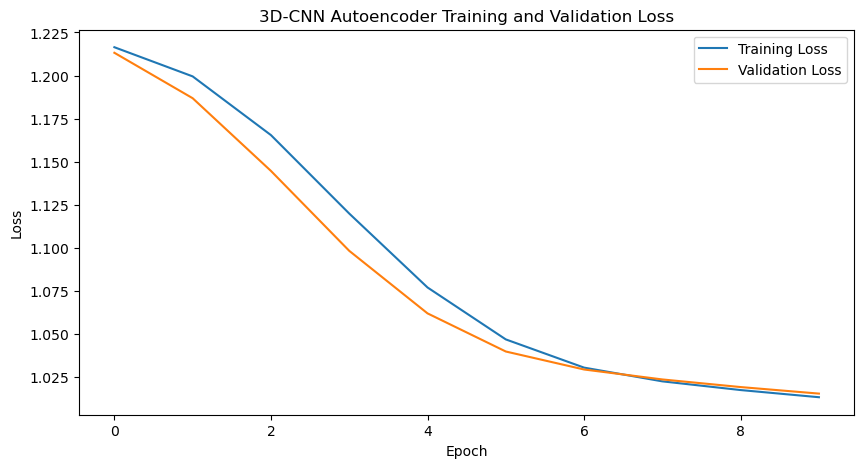

In [5]:
autoencoder = Autoencoder3D().to(device)
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion_ae = nn.MSELoss()

# Training loop for autoencoder
autoencoder.train()
num_epochs_ae = 10

train_losses_ae = []
valid_losses_ae = []

for epoch in range(num_epochs_ae):
    # Training phase
    autoencoder.train()
    total_train_loss = 0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer_ae.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion_ae(outputs, inputs)
        loss.backward()
        optimizer_ae.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses_ae.append(avg_train_loss)
    
    # Validation phase
    autoencoder.eval()
    total_valid_loss = 0
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = autoencoder(inputs)
            loss = criterion_ae(outputs, inputs)
            total_valid_loss += loss.item()
    avg_valid_loss = total_valid_loss / len(test_loader)
    valid_losses_ae.append(avg_valid_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Valid Loss: {avg_valid_loss}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses_ae, label='Training Loss')
plt.plot(valid_losses_ae, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('3D-CNN Autoencoder Training and Validation Loss')
plt.legend()
plt.show()


In [8]:
# Function to get encoded features 
def get_encoded_features(model, loader):
    model.eval()
    features = []
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            encoded = model.encoder(data)
            features.append(encoded.view(data.size(0), -1))  # Flatten encoded features
    return torch.cat(features, dim=0)


In [14]:
#getting latent space for training dataset
encoded_train = get_encoded_features(autoencoder, train_loader) 
encoded_dim = encoded_train.size(1)  # to captures the correct input dimension 

encoded_train.shape, encoded_dim

(torch.Size([80, 5000]), 5000)

In [22]:
# preparing encoded data for LSTM training
train_labels = train_time_series_responses.view(-1, time_series_length).to(device)
train_dataset_lstm = TensorDataset(encoded_train, train_labels)
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=batch_size, shuffle=True)
train_labels.shape

torch.Size([80, 150])

In [23]:
#getting latent space for test dataset
encoded_test = get_encoded_features(autoencoder, test_loader)
encoded_test_dim = encoded_test.size(1)

encoded_test.shape, encoded_test_dim

(torch.Size([20, 5000]), 5000)

In [24]:
# preparing encoded data for LSTM testing
test_labels = test_time_series_responses.view(-1, time_series_length).to(device)
test_dataset_lstm = TensorDataset(encoded_test, test_labels)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=batch_size, shuffle=False)
test_labels.shape

torch.Size([20, 150])

In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc(lstm_out[:, -1, :])
        return x


In [29]:
# LSTM model instantiation with the correct input dimension
hidden_dim = 50
lstm_model = LSTMModel(encoded_dim, hidden_dim, time_series_length).to(device)

optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion_lstm = nn.MSELoss()

train_losses_lstm = []
test_losses_lstm = []



In [32]:
num_epochs_lstm = 10

for epoch in range(num_epochs_lstm):
    
    #training phase
    lstm_model.train()
    total_train_loss = 0.0
    
    for data, labels in train_loader_lstm:
        data, labels = data.to(device), labels.to(device)
        optimizer_lstm.zero_grad()
        output = lstm_model(data.unsqueeze(1))  # may need to adjust input for LSTM if needed
        loss = criterion_lstm(output, labels)
        loss.backward()
        optimizer_lstm.step()
        total_train_loss += loss.item()
        
    avg_train_loss = total_train_loss / len(train_loader_lstm)
    train_losses_lstm.append(avg_train_loss)
    
    # Validation phase
    lstm_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for data, labels in test_loader_lstm:
            data, labels = data.to(device), labels.to(device)
            output = lstm_model(data.unsqueeze(1))  
            loss = criterion_lstm(output, labels)
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(test_loader_lstm)
    test_losses_lstm.append(avg_val_loss)  # Considered renaming to val_losses_lstm for clarity
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


Epoch 1, Train Loss: 1.0261, Val Loss: 1.0127
Epoch 2, Train Loss: 1.0239, Val Loss: 1.0125
Epoch 3, Train Loss: 1.0223, Val Loss: 1.0125
Epoch 4, Train Loss: 1.0209, Val Loss: 1.0124
Epoch 5, Train Loss: 1.0200, Val Loss: 1.0127
Epoch 6, Train Loss: 1.0193, Val Loss: 1.0130
Epoch 7, Train Loss: 1.0186, Val Loss: 1.0133
Epoch 8, Train Loss: 1.0182, Val Loss: 1.0137
Epoch 9, Train Loss: 1.0179, Val Loss: 1.0140
Epoch 10, Train Loss: 1.0177, Val Loss: 1.0145
